In [1]:
%matplotlib inline

import pickle
import pymc3 as pm
import numpy as np
import arviz as az
import matplotlib.pyplot as plt
import theano.tensor as tt
from scipy.stats import multinomial

np.random.seed(0)

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# Tutorial on MDP inference and solution

In this tutorial we will see how to infer an MDP model, namely the parameters that compose the transition dynamics, and how to find the optimal policy via Bellman equation.

## 1. MDP true model and data generation

Before inferring and solving the MDP, we need to define the true underlying model and sample some data from it, which will then be used for our inference. We consider an MDP with 3 states and 2 actions:

In [2]:
n_states = 3
n_actions = 2

As states and actions are discrete, the transition dynamics is formed by transition matrices. Specifically, one transition matrix `n_states` $\times$ `n_states` per action. The transition matrices and the initial state probability distribution are defined as follows:

In [3]:
p_init = np.array([1/3., 1/3., 1/3.])

p_transition_0 = np.array(
    [[0.90, 0.09, 0.01],
     [0.01, 0.90, 0.09],
     [0.01, 0.05, 0.94]]
)
p_transition_1 = np.array(
    [[1.  , 0.  , 0.  ],
     [0.9 , 0.1 , 0.  ],
     [0.49, 0.5 , 0.01]]
)
p_transitions = np.array([p_transition_0, p_transition_1])
p_transitions

array([[[0.9 , 0.09, 0.01],
        [0.01, 0.9 , 0.09],
        [0.01, 0.05, 0.94]],

       [[1.  , 0.  , 0.  ],
        [0.9 , 0.1 , 0.  ],
        [0.49, 0.5 , 0.01]]])

In the transition matrices, entry $ij$ is defined as the probability to transition from state $i$ to state $j$, when the action associated with the transition matix is taken.

We define a function to sample some trajectories from the MDP:

In [4]:
def mdp_sequence(p_init: np.array, p_actions:np.array, p_transitions: np.array, horizon: int):
    """
    Generate a Markov Decision Process sequence based on p_init, p_actions and p_transitions.
    """
    initial_state = list(multinomial.rvs(1, p_init)).index(1)
    initial_action = list(multinomial.rvs(1, p_actions)).index(1)

    states = [initial_state]
    actions = [initial_action]
    for _ in range(horizon - 1):
        p_tr = p_transitions[actions[-1], states[-1]]
        new_state = list(multinomial.rvs(1, p_tr)).index(1)
        new_action = list(multinomial.rvs(1, p_actions)).index(1)
        states.append(new_state)
        actions.append(new_action)
    return states, actions

def generate_multiple_mdp_seq(horizon, number_trajectories, p_transitions, p_init, p_actions): 
    """
    Generate multiple POMDP sequences.
    """
    #Generating a Markov Sequence
    states_all_seq = np.full((number_trajectories, horizon), np.nan)
    actions_all_seq = np.full((number_trajectories, horizon), np.nan)
    for i in range(number_trajectories):
        states, actions = mdp_sequence(p_init, p_actions, p_transitions, horizon)
        states_all_seq[i, :] = states
        actions_all_seq[i, :] = actions
    states_all_seq = states_all_seq.astype(int)
    actions_all_seq = actions_all_seq.astype(int)
    return states_all_seq, actions_all_seq

For simplicity, we also define a probability distribution over the two actions to sample our trajectories. Usually, these trajectories come from offline collected data, where actions follow for example some human policies. 

In [5]:
horizon = 50
number_trajectories = 10
p_actions = np.array([0.8, 0.2])
states_all_seq, actions_all_seq = generate_multiple_mdp_seq(
    horizon, number_trajectories, p_transitions, p_init, p_actions
)

Plot the first trajectory:

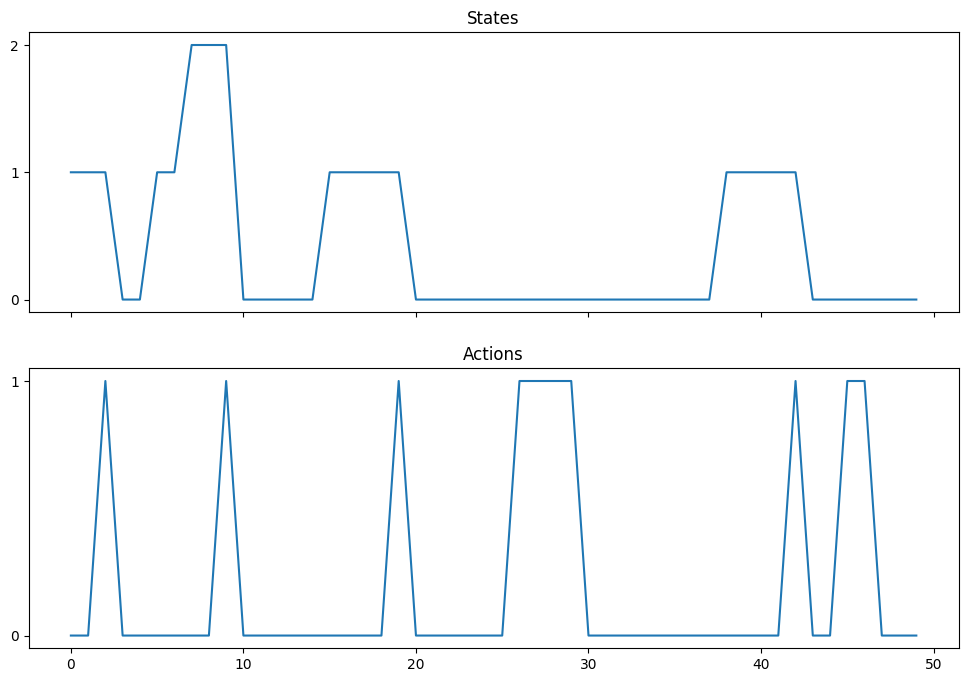

In [6]:
fig, axes = plt.subplots(figsize=(12, 8), nrows=2, ncols=1, sharex=True)
axes[0].plot(states_all_seq[0, :])
axes[0].set_title("States")
axes[0].set_yticks([0, 1, 2])
axes[1].plot(actions_all_seq[0, :])
axes[1].set_title("Actions")
axes[1].set_yticks([0, 1])
plt.show()

## 2. MDP Inference

In this section we will infer the initial state probability and the transition matrices, given the trajectories of observed states and actions. As the states are discrete, the observation model is defined with Categorical distributions based on the inferred model parameters.

In [7]:
class States(pm.Categorical):
    def __init__(self, p_transition, init_prob, actions, n_states, *args, **kwargs): # p_transition and init_prob are to be inferred
        super(pm.Categorical, self).__init__(*args, **kwargs)
        self.p_transition = p_transition
        self.init_prob = init_prob
        self.actions = actions
        self.k = n_states
        self.mode = tt.cast(0,dtype='int64')

    def logp(self, x):
        p_init = self.init_prob
        acts = self.actions[:-1]
        p_tr = self.p_transition[acts, x[:-1]]

        # the logp of the initial state 
        initial_state_logp = pm.Categorical.dist(p_init).logp(x[0])

        # the logp of the rest of the states.
        x_i = x[1:]
        ou_like = pm.Categorical.dist(p_tr).logp(x_i)
        transition_logp = tt.sum(ou_like)
        return initial_state_logp + transition_logp

We infer the MDP model by modeling the initial state probability and the transition matrices with Dirichlet distributions. The inferred paremeters  are used by `States` to compute the likelihood of our samples. The MCMC samples are accepted or rejected based on this likelihood and new samples are proposed via the NUTS algorithm (default in pymc3 for continuous parameters).

In [8]:
with pm.Model() as mdp_model:
    transition_mat = pm.Dirichlet(
        "p_transition",
        a=tt.ones((n_actions, n_states, n_states)), # We use a flat prior, but more strongly regularizing priors are usually suggested
        shape=(n_actions, n_states, n_states))
    
    init_probs = pm.Dirichlet('init_probs', a = tt.ones((n_states,)), shape=n_states)
    
    for i in range(number_trajectories):
        obs_states = States(
            "states_" + str(i),
            p_transition=transition_mat,
            init_prob=init_probs,
            actions=actions_all_seq[i, :],
            n_states=n_states,
            observed=np.array(states_all_seq[i, :]).astype("float")
        )
    
    #trace = pm.sample(3000, tune=2000, target_accept=0.9) # Uncomment to run the inference

/tmp/ipykernel_10750/1485897842.py:19: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(3000, tune=2000, target_accept=0.9)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [init_probs, p_transition]


Sampling 4 chains for 2_000 tune and 3_000 draw iterations (8_000 + 12_000 draws total) took 251 seconds.


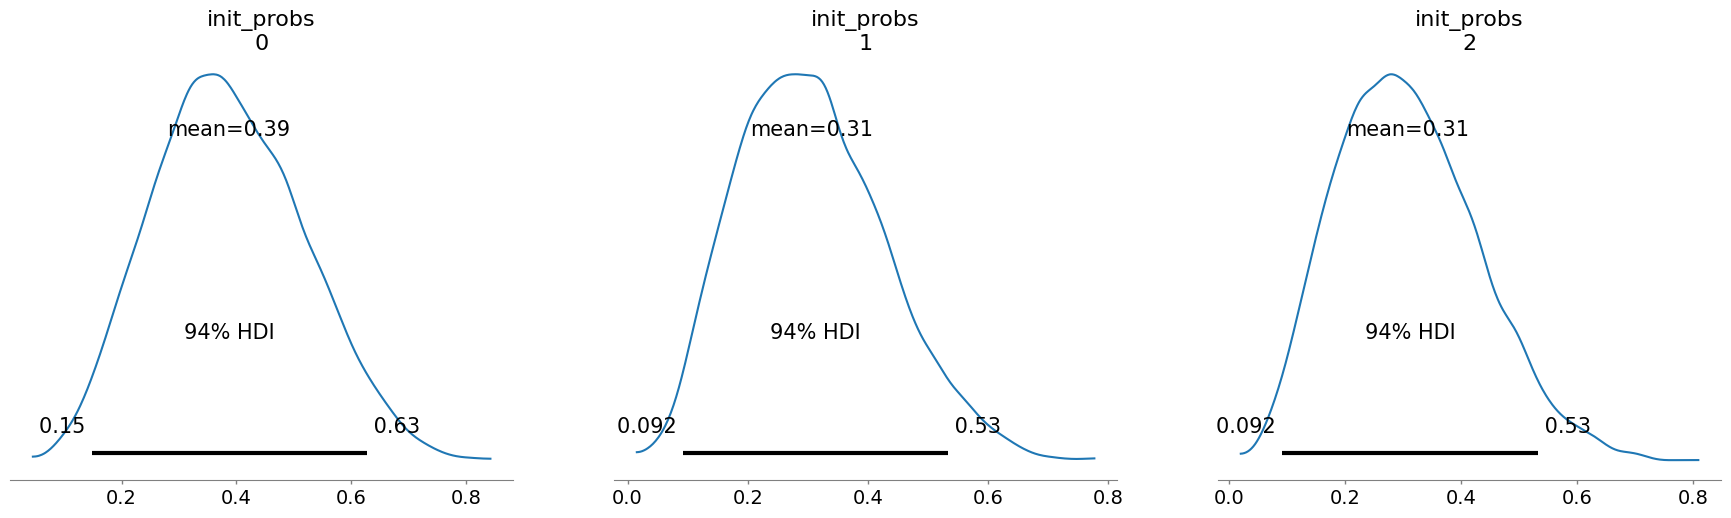

In [9]:
with mdp_model:
    az.plot_posterior(trace,  var_names=["init_probs"]);

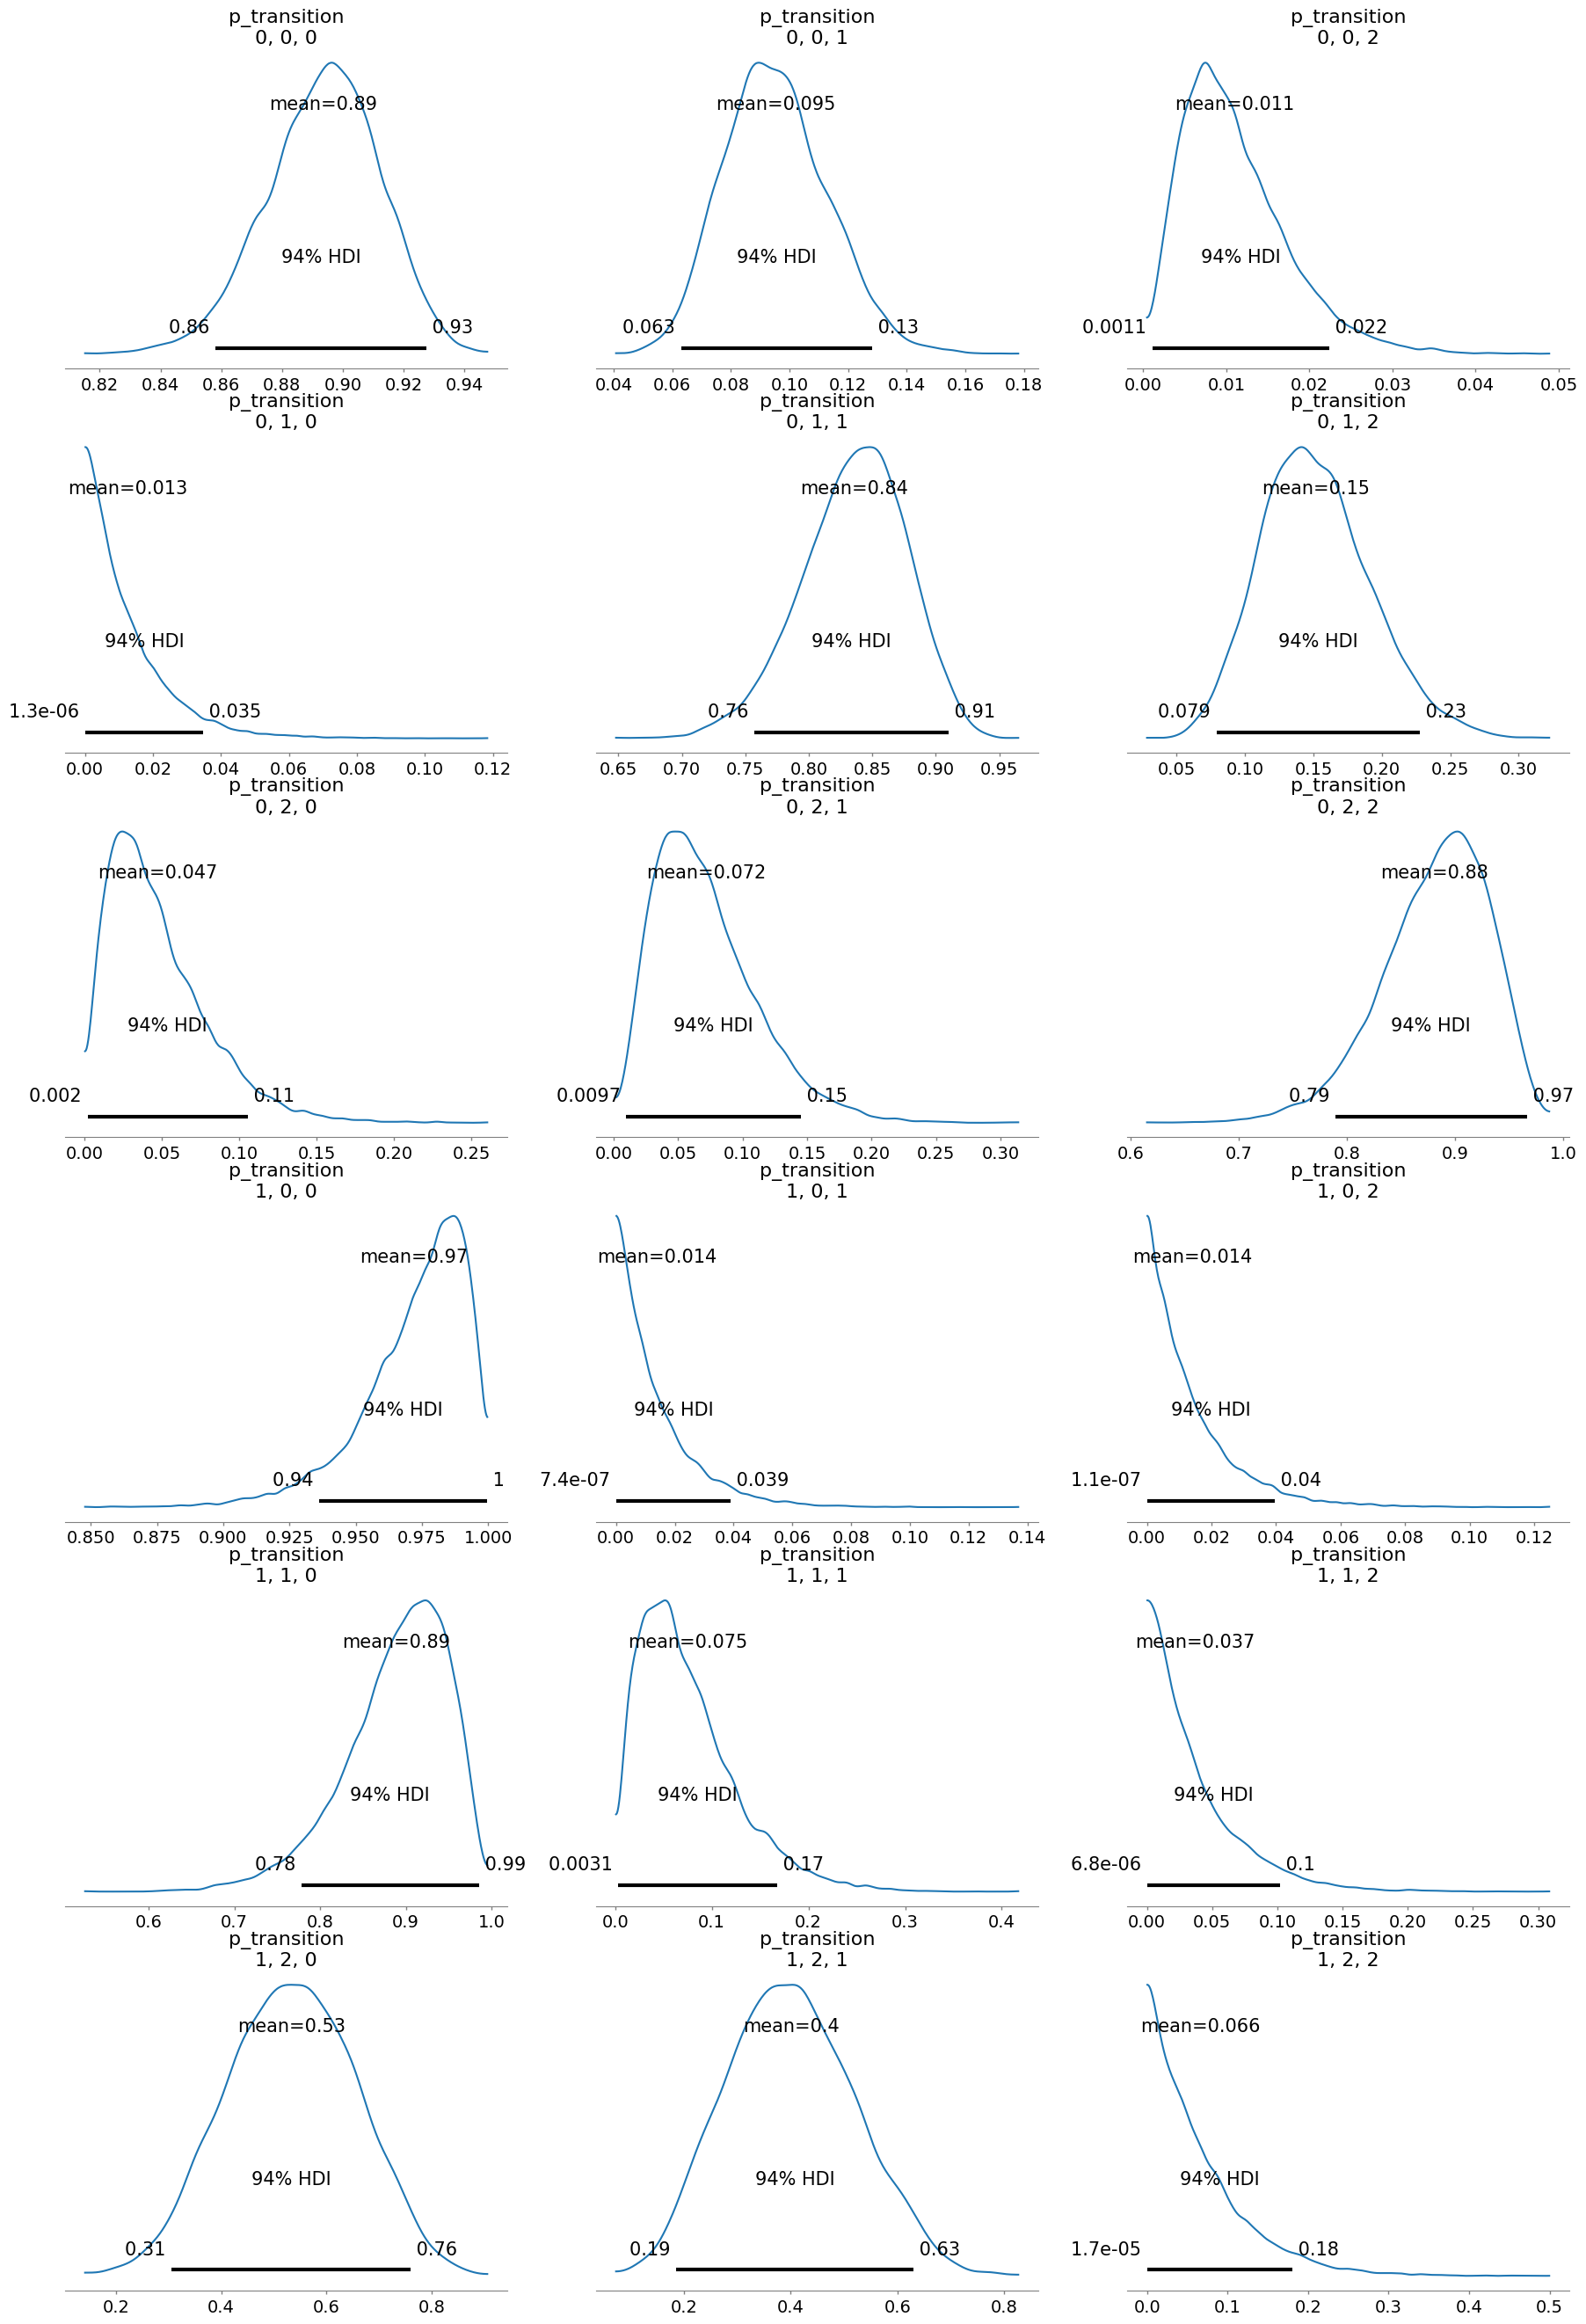

In [10]:
with mdp_model:
    az.plot_posterior(trace,  var_names=["p_transition"]);

In [17]:
#mdp_parameters = {}
#mdp_parameters["inferred_p_init"] = trace["init_probs"]
#mdp_parameters["inferred_p_transitions"] = trace["p_transition"]
#
#file = 'mdp_parameters.pickle'
#with open(file, "wb") as fp:
#    pickle.dump(mdp_parameters, fp)

In [22]:
file = 'mdp_parameters.pickle'
with open(file, "rb") as fp:
    mdp_parameters = pickle.load(fp)

inferred_p_init_mean = mdp_parameters["inferred_p_init"].mean(0)
inferred_p_transitions_mean = mdp_parameters["inferred_p_transitions"].mean(0)

Let us compare the ground truth parameters with the inferred mean parameters:

In [23]:
print(f"Ground truth initial state probabilities:\n{p_init}")
print(f"Inferred mean state initial state probabilities:\n{inferred_p_init_mean.round(2)}")

Ground truth initial state probabilities:
[0.33333333 0.33333333 0.33333333]
Inferred mean state initial state probabilities:
[0.39 0.31 0.31]


In [24]:
print(f"Ground truth transition matrices:\n{p_transitions}")
print(f"Inferred mean transition matrices:\n{inferred_p_transitions_mean.round(2)}")

Ground truth transition matrices:
[[[0.9  0.09 0.01]
  [0.01 0.9  0.09]
  [0.01 0.05 0.94]]

 [[1.   0.   0.  ]
  [0.9  0.1  0.  ]
  [0.49 0.5  0.01]]]
Inferred mean transition matrices:
[[[0.89 0.1  0.01]
  [0.01 0.84 0.15]
  [0.05 0.07 0.88]]

 [[0.97 0.01 0.01]
  [0.89 0.07 0.04]
  [0.53 0.4  0.07]]]


Pretty good!

## 3. MDP solution

We now compute the optimal policy given the inferred mean parameters through Bellman equation. First we need to define our reward/cost function $r_t=r(s_t, a_t)$:

In [25]:
# Define rewards
reward_a_0 = - 0
reward_a_1 = - 200 


reward_s_0 = - 10
reward_s_1 = - 100
reward_s_2 = - 800

# Define reward matrix where entry ij is the reward of taking action i at state j
reward_matrix = np.asarray([
    [reward_a_0 + reward_s_0, reward_a_0 + reward_s_1, reward_a_0 + reward_s_2],
    [reward_a_1 + reward_s_0, reward_a_1 + reward_s_1, reward_a_1 + reward_s_2],
])

reward_matrix

array([[  -10,  -100,  -800],
       [ -210,  -300, -1000]])

Define the functions to compute Bellman operator and the finite horizon Q-values.

<span style="color:red"><ins>Task: </ins></span> Compute Bellman operator.

In [28]:
def bellmanOperator(transition_matrices, reward_matrix, V):
    A, S = reward_matrix.shape 
    Q = np.empty((A, S))
    for a in range(A):

        ### TASK: write here your solution
        Q[a] = 
        
    return Q, Q.max(axis=0)

def finite_horizon_q_values(transition_matrices, reward_matrix, N): # N is the horizon
    A, S = reward_matrix.shape 
    Q = np.empty((A, S , N))
    V = np.zeros((S, N+1))
    for i in range(N):
        q, v = bellmanOperator(transition_matrices, reward_matrix, V[:, N - i])
        stage = N - i - 1
        V[:, stage] = v
        Q[:, :, stage] = q
    return Q

In [29]:
q_values = finite_horizon_q_values(
    transition_matrices=inferred_p_transitions_mean, reward_matrix=reward_matrix, N=50
)

Let's test our solution on the true model.

<span style="color:red"><ins>Task: </ins></span> Compute the optimal action.

In [48]:
tot_rewards = 0
state = multinomial.rvs(1, p_init).argmax() # Sample from true model
for timestep in range(50):

    ### TASK: write here your solution
    action = 
    
    reward = reward_matrix[action, state]
    p_tr = p_transitions[action, state] # Sample from true model
    next_state = multinomial.rvs(1, p_tr).argmax()
    print(f"Timestep {timestep}\nState {state}\nAction {action}\nReward {reward}\n")
    tot_rewards += reward
    state = next_state
print(f"Total rewards {tot_rewards}\n")

Timestep 0
State 2
Action 1
Reward -1000

Timestep 1
State 0
Action 0
Reward -10

Timestep 2
State 0
Action 0
Reward -10

Timestep 3
State 0
Action 0
Reward -10

Timestep 4
State 0
Action 0
Reward -10

Timestep 5
State 0
Action 0
Reward -10

Timestep 6
State 0
Action 0
Reward -10

Timestep 7
State 1
Action 1
Reward -300

Timestep 8
State 0
Action 0
Reward -10

Timestep 9
State 0
Action 0
Reward -10

Timestep 10
State 0
Action 0
Reward -10

Timestep 11
State 1
Action 1
Reward -300

Timestep 12
State 0
Action 0
Reward -10

Timestep 13
State 0
Action 0
Reward -10

Timestep 14
State 0
Action 0
Reward -10

Timestep 15
State 0
Action 0
Reward -10

Timestep 16
State 1
Action 1
Reward -300

Timestep 17
State 0
Action 0
Reward -10

Timestep 18
State 0
Action 0
Reward -10

Timestep 19
State 0
Action 0
Reward -10

Timestep 20
State 0
Action 0
Reward -10

Timestep 21
State 0
Action 0
Reward -10

Timestep 22
State 0
Action 0
Reward -10

Timestep 23
State 0
Action 0
Reward -10

Timestep 24
State 0
A

<span style="color:red"><ins>Optional task: </ins></span> Compute the Q-values given the true model and check whether there are differences.